In [1]:
!pip install torch==2.7.0
!pip install torch-geometric
!pip install biopython
!pip install obonet
!pip install networkx
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scipy
!pip install scikit-learn
!pip install fair-esm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.0/865.0 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 MB 7.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-cusparselt-cu12
    Found existing installation: nvidia-cusparselt-cu12 0.7.1
    Uninstalling nvidia-cusparselt-cu12-0.7.1:
      Successfully uninstalled nvidia-cusparselt-cu12-0.7.1
  Attempting uninstall: triton
    Found existing installation: triton 3.4.0
    Uninstalling triton-3.4.0:
      Successfully uninstalled triton-3.4.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.27.3
    Uninstalling nvidia-nccl-cu12-2.27.3:
      Successfully uninstalled nvidia-nccl-cu12-2.27.3
  Attempting uninstall: nvidia-cudnn-

In [1]:
import os
import torch
import torch_geometric
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import Bio
from Bio import SeqIO
import obonet
import gc
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import random
import esm


In [2]:
obo_path = '/content/go-basic.obo'
fasta_path = '/content/train_sequences.fasta'
term_path = '/content/train_terms.tsv'

In [3]:
graph = obonet.read_obo(obo_path)


nodes = pd.DataFrame.from_dict(dict(graph.nodes(data=True)), orient='index')
nodes.reset_index(inplace=True)
nodes.rename(columns={'index': 'id'}, inplace=True)

edges = pd.DataFrame([
    {'source': u, 'target': v, 'relation': data.get('relation', 'is_a')}
    for u, v, data in graph.edges(data=True)
])

print("Number of nodes:", len(nodes))
print("Number of edges:", len(edges))

print("\nSample nodes:")
print(nodes.head())

print("\nSample edges:")
print(edges.head())

Number of nodes: 40122
Number of edges: 77229

Sample nodes:
           id                                               name  \
0  GO:0000001                          mitochondrion inheritance   
1  GO:0000002                   mitochondrial genome maintenance   
2  GO:0000006  high-affinity zinc transmembrane transporter a...   
3  GO:0000007  low-affinity zinc ion transmembrane transporte...   
4  GO:0000009             alpha-1,6-mannosyltransferase activity   

            namespace                                                def  \
0  biological_process  "The distribution of mitochondria, including t...   
1  biological_process  "The maintenance of the structure and integrit...   
2  molecular_function  "Enables the transfer of zinc ions (Zn2+) from...   
3  molecular_function  "Enables the transfer of a solute or solutes f...   
4  molecular_function  "Catalysis of the transfer of a mannose residu...   

                                             synonym  \
0             ["m

### Visualize the GO graph for 1% sampled edges

Loaded 40122 nodes and 77229 edges
Sampled 77 edges
Subgraph has 154 nodes and 77 edges


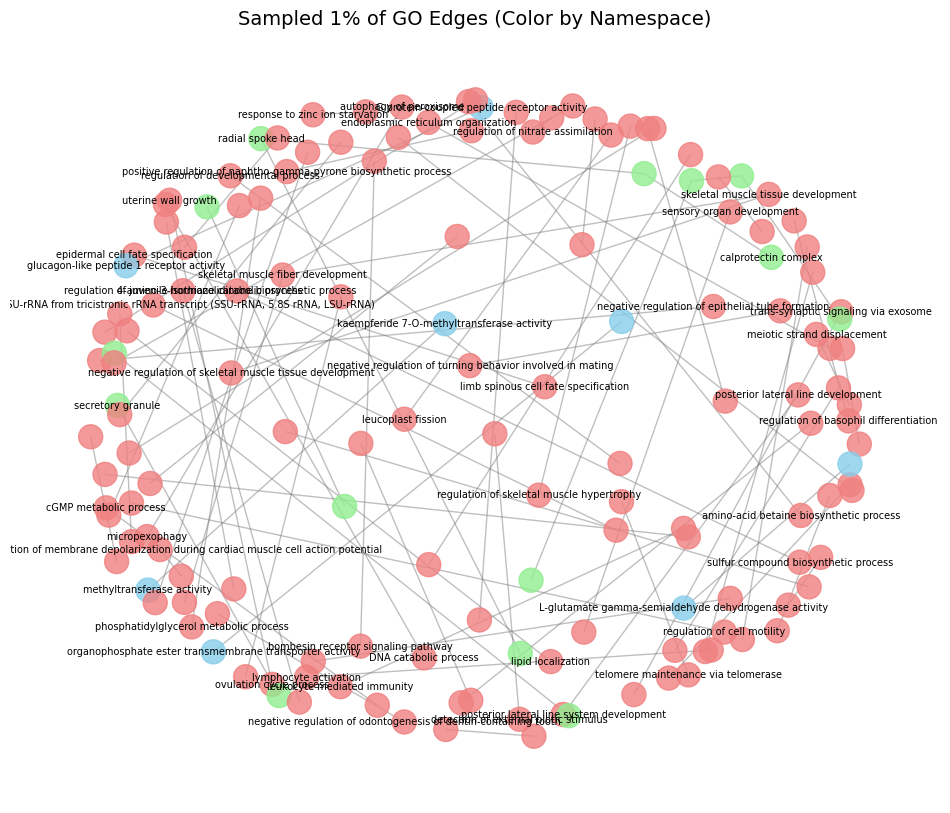

In [4]:

nodes = pd.DataFrame.from_dict(dict(graph.nodes(data=True)), orient='index').reset_index()
nodes.rename(columns={'index': 'id'}, inplace=True)

edges = pd.DataFrame([
    {'source': u, 'target': v, 'relation': data.get('relation', 'is_a')}
    for u, v, data in graph.edges(data=True)
])

print(f"Loaded {len(nodes)} nodes and {len(edges)} edges")

# ------------------------------
# Step 3: Sample 1% of edges
# ------------------------------
sampled_edges = edges.sample(frac=0.001, random_state=42).reset_index(drop=True)
print(f"Sampled {len(sampled_edges)} edges")


sampled_node_ids = set(sampled_edges['source']).union(set(sampled_edges['target']))
sampled_nodes = nodes[nodes['id'].isin(sampled_node_ids)]

print(f"Subgraph has {len(sampled_nodes)} nodes and {len(sampled_edges)} edges")


subgraph = graph.subgraph(sampled_node_ids).copy()


plt.figure(figsize=(12, 10))

pos = nx.spring_layout(subgraph, k=0.8, seed=42)


namespace_colors = {
    'biological_process': 'lightcoral',
    'molecular_function': 'skyblue',
    'cellular_component': 'lightgreen'
}
node_colors = [
    namespace_colors.get(subgraph.nodes[n].get('namespace', ''), 'gray')
    for n in subgraph.nodes()
]


nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=300, alpha=0.8)
nx.draw_networkx_edges(subgraph, pos, arrows=False, edge_color='gray', alpha=0.5)


label_nodes = dict(list(subgraph.nodes(data=True))[:50])
nx.draw_networkx_labels(
    subgraph,
    pos,
    labels={n: d.get('name', n) for n, d in label_nodes.items()},
    font_size=7
)

plt.title("Sampled 1% of GO Edges (Color by Namespace)", fontsize=14)
plt.axis('off')
plt.show()


### Create set of embedding from the graph edges using GCN

In [32]:
# ---------------------------------------------------
# Read TSV and Sample by EntryID
# ---------------------------------------------------
def sample_tsv(file_path, sample_frac=0.05, random_state=42):
    """
    Read a TSV file and sample based on unique EntryID.
    Pulls in all associated rows for sampled EntryIDs.
    """
    df = pd.read_csv(file_path, sep='\t')
    unique_ids = df['EntryID'].unique()
    sample_size = max(1, int(len(unique_ids) * sample_frac))
    sampled_ids = random.sample(list(unique_ids), sample_size)
    sampled_df = df[df['EntryID'].isin(sampled_ids)]
    print(f"Sampled {len(sampled_df)} rows from {len(unique_ids)} unique EntryIDs")
    return sampled_df


In [33]:
def create_go_embeddings_optimized(obo_path, go_terms, embed_dim=16, hidden_dim=32, out_dim=16, epochs=50):

    print(" Loading Gene Ontology...")
    graph = obonet.read_obo(obo_path)


    edges = pd.DataFrame([
        {'source': u, 'target': v, 'relation': data.get('relation', 'is_a')}
        for u, v, data in graph.edges(data=True)
    ])

    relevant_edges = edges[
        edges['source'].isin(go_terms) | edges['target'].isin(go_terms)
    ].reset_index(drop=True)

    nodes = pd.DataFrame({'id': list(set(relevant_edges['source']).union(relevant_edges['target']))})
    nodes['node_idx'] = range(len(nodes))
    node2idx = dict(zip(nodes['id'], nodes['node_idx']))

    edge_index = torch.tensor([
        [node2idx[s] for s in relevant_edges['source']],
        [node2idx[t] for t in relevant_edges['target']]
    ], dtype=torch.long)

    num_nodes = len(nodes)
    print(f"Using {num_nodes} GO terms and {len(relevant_edges)} edges")


    x = torch.randn((num_nodes, embed_dim), dtype=torch.float32)


    class SimpleGCN(nn.Module):
        def __init__(self, in_dim, hidden_dim, out_dim):
            super(SimpleGCN, self).__init__()
            self.conv1 = GCNConv(in_dim, hidden_dim)
            self.conv2 = GCNConv(hidden_dim, out_dim)

        def forward(self, x, edge_index):
            x = self.conv1(x, edge_index)
            x = F.relu(x)
            x = self.conv2(x, edge_index)
            return x

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleGCN(embed_dim, hidden_dim, out_dim).to(device)


    x = x.to(device)
    edge_index = edge_index.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    data = Data(x=x, edge_index=edge_index)

    print(f"Training on device: {device}")
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        embeddings = model(data.x, data.edge_index)
        # Inner product decoder
        recon = torch.sigmoid(torch.matmul(embeddings, embeddings.T))
        adj_true = torch.zeros_like(recon)
        adj_true[data.edge_index[0], data.edge_index[1]] = 1.0

        loss = F.binary_cross_entropy(recon, adj_true)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f}")


    with torch.no_grad():
        node_embeddings = model(data.x, data.edge_index).cpu().numpy()

    del model, x, data, recon, adj_true
    torch.cuda.empty_cache()
    gc.collect()

    col_names = [f"go_emb_{i}" for i in range(node_embeddings.shape[1])]

    emb_df = pd.DataFrame(node_embeddings, index=nodes['id'], columns=col_names)
    print(f"Created embeddings for {len(emb_df)} GO terms")
    return emb_df





In [34]:
# ---------------------------------------------------
# Pull protein sequences from FASTA file
# ---------------------------------------------------
def extract_sequences(fasta_path, entry_ids):
    records = []
    entry_ids = set(entry_ids)
    for record in SeqIO.parse(fasta_path, "fasta"):
        # Typical Uniprot headers: ">sp|P12345|PROT_HUMAN ..."
        label = record.id.split('|')[1] if '|' in record.id else record.id
        if label in entry_ids:
            records.append({
                'EntryID': label,
                'Sequence': str(record.seq)
            })
    seq_df = pd.DataFrame(records)
    print(f"Retrieved {len(seq_df)} sequences matching EntryIDs")
    return seq_df



### Sample 0.5% of the data and create embedding based on that

In [35]:
sampled_data = sample_tsv(term_path, sample_frac=0.005)
go_terms = sampled_data['term'].unique()
embeddings_df = create_go_embeddings_optimized(obo_path, go_terms)
seq_df = extract_sequences(fasta_path, sampled_data['EntryID'])

Sampled 2596 rows from 82404 unique EntryIDs
 Loading Gene Ontology...
Using 10399 GO terms and 11234 edges
Training on device: cuda
Epoch 000 | Loss: 2.9106
Epoch 010 | Loss: 0.8137
Epoch 020 | Loss: 0.7849
Epoch 030 | Loss: 0.7219
Epoch 040 | Loss: 0.7066
Epoch 049 | Loss: 0.7046
Created embeddings for 10399 GO terms
Retrieved 412 sequences matching EntryIDs


In [36]:
torch.cuda.empty_cache()

### Create embedding using Protein Language Model

In [37]:
def generate_protein_embeddings_esm_optimized(seq_df, seq_col='Sequence', entryid_col='EntryID',
                                              target_dim=16, batch_size=1, use_fp16=True):
    """
    Memory-optimized ESM embedding generation for proteins.
    Processes small batches and moves embeddings to CPU immediately.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # Load pretrained ESM model
    model, alphabet = esm.pretrained.esm2_t30_150M_UR50D()
    model = model.to(device)
    model.eval()

    batch_converter = alphabet.get_batch_converter()

    sequences = seq_df[seq_col].tolist()
    entry_ids = seq_df[entryid_col].tolist()

    all_embeddings = []

    for i in range(0, len(sequences), batch_size):
        batch_seqs = sequences[i:i+batch_size]
        batch_labels = entry_ids[i:i+batch_size]

        batch_data = [(label, seq) for label, seq in zip(batch_labels, batch_seqs)]
        _, _, batch_tokens = batch_converter(batch_data)
        batch_tokens = batch_tokens.to(device)

        with torch.no_grad():
            results = model(batch_tokens, repr_layers=[model.num_layers], return_contacts=False)
            token_embeddings = results["representations"][model.num_layers]  # (B, L, D)

            # Mean pool over sequence length
            attention_mask = batch_tokens != alphabet.padding_idx
            masked_embeddings = token_embeddings * attention_mask.unsqueeze(-1)
            seq_lengths = attention_mask.sum(dim=1).unsqueeze(-1)
            seq_embeddings = (masked_embeddings.sum(dim=1) / seq_lengths).cpu().float().numpy()

        all_embeddings.append(seq_embeddings)
        del batch_tokens, token_embeddings, masked_embeddings, seq_embeddings
        torch.cuda.empty_cache()

    raw_embeddings = np.vstack(all_embeddings)
    print("Raw embeddings shape:", raw_embeddings.shape)

    if raw_embeddings.shape[1] > target_dim:
        pca = PCA(n_components=target_dim)
        reduced = pca.fit_transform(raw_embeddings)
    else:
        reduced = np.zeros((raw_embeddings.shape[0], target_dim), dtype=np.float32)
        reduced[:, :raw_embeddings.shape[1]] = raw_embeddings

    col_names = [f"prot_emb_{i}" for i in range(target_dim)]
    emb_df = pd.DataFrame(reduced, index=entry_ids, columns=col_names)
    emb_df.index.name = entryid_col
    print("Reduced embeddings shape:", emb_df.shape)
    return emb_df


prot_emb_df = generate_protein_embeddings_esm_optimized(seq_df, seq_col='Sequence', entryid_col='EntryID', target_dim=16)

# Merge with sampled_data if needed
merged = sampled_data.merge(prot_emb_df, how='left', left_on='EntryID', right_index=True)
print(merged.head())


Using device: cuda
Raw embeddings shape: (412, 640)
Reduced embeddings shape: (412, 16)
     EntryID        term aspect  prot_emb_0  prot_emb_1  prot_emb_2  \
1655  P39735  GO:0070337      F   -2.099753    0.596831    0.287619   
1656  P39735  GO:0070338      F   -2.099753    0.596831    0.287619   
1657  P39735  GO:0000403      F   -2.099753    0.596831    0.287619   
1658  P39735  GO:0000405      F   -2.099753    0.596831    0.287619   
1659  P39735  GO:0000736      P   -2.099753    0.596831    0.287619   

      prot_emb_3  prot_emb_4  prot_emb_5  prot_emb_6  prot_emb_7  prot_emb_8  \
1655   -0.710473     -0.2652    0.040358   -0.189175    0.169962   -0.483808   
1656   -0.710473     -0.2652    0.040358   -0.189175    0.169962   -0.483808   
1657   -0.710473     -0.2652    0.040358   -0.189175    0.169962   -0.483808   
1658   -0.710473     -0.2652    0.040358   -0.189175    0.169962   -0.483808   
1659   -0.710473     -0.2652    0.040358   -0.189175    0.169962   -0.483808   

    

### Combine GO embedding and PLM embedding into one dataset

In [38]:
def combine_go_protein_embeddings(sampled_data, go_emb_df, prot_emb_df):

    combined = sampled_data.merge(go_emb_df, how='left', left_on='term', right_index=True)

    combined = combined.merge(prot_emb_df, how='left', left_on='EntryID', right_index=True)

    return combined


multimodal_df = combine_go_protein_embeddings(sampled_data, embeddings_df, prot_emb_df)

print("Multimodal feature dataframe shape:", multimodal_df.shape)
print(multimodal_df.head())

Multimodal feature dataframe shape: (2596, 35)
     EntryID        term aspect  go_emb_0  go_emb_1  go_emb_2  go_emb_3  \
1655  P39735  GO:0070337      F -0.275961 -0.143684  0.153924 -0.065060   
1656  P39735  GO:0070338      F -0.317174 -0.160727  0.032085  0.046305   
1657  P39735  GO:0000403      F -0.333993  0.416880  0.742065  0.437789   
1658  P39735  GO:0000405      F  0.134317 -0.124207 -0.207291  0.341261   
1659  P39735  GO:0000736      P  0.144092  0.538833 -0.016788 -0.160519   

      go_emb_4  go_emb_5  go_emb_6  ...  prot_emb_6  prot_emb_7  prot_emb_8  \
1655 -0.442844 -0.117650 -0.115812  ...   -0.189175    0.169962   -0.483808   
1656  0.217443 -0.102285 -0.099930  ...   -0.189175    0.169962   -0.483808   
1657 -0.087390 -0.200164 -0.064737  ...   -0.189175    0.169962   -0.483808   
1658  0.319669 -0.323743  0.225260  ...   -0.189175    0.169962   -0.483808   
1659  0.247915 -0.154402 -0.023533  ...   -0.189175    0.169962   -0.483808   

      prot_emb_9  prot_emb_

### Create a simple NN model for baseline

In [45]:
feature_cols = [col for col in multimodal_df.columns if col.startswith('prot_emb_')]

# If we are using GO embedding as well
# feature_cols = [col for col in multimodal_df.columns if col.startswith('go_emb_') or col.startswith('prot_emb_')]
X = multimodal_df[feature_cols].values
y = multimodal_df['aspect'].values


le = LabelEncoder()
y_encoded = le.fit_transform(y)


X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y_encoded, dtype=torch.long)


X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [46]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_dim = X_train.shape[1]
hidden_dim = 64
num_classes = len(le.classes_)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN(input_dim, hidden_dim, num_classes).to(device)


In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 30

train_losses = []
val_losses = []
train_accs = []
val_accs = []


In [48]:
for epoch in range(num_epochs):
    # ------------------ Training ------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    train_losses.append(running_loss / total)
    train_accs.append(correct / total)

    # ------------------ Validation ------------------
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    val_losses.append(val_loss / total)
    val_accs.append(correct / total)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_losses[-1]:.4f}, Acc: {train_accs[-1]:.4f} | "
          f"Val Loss: {val_losses[-1]:.4f}, Acc: {val_accs[-1]:.4f}")


Epoch 1/30 | Train Loss: 1.0704, Acc: 0.4542 | Val Loss: 1.0474, Acc: 0.4904
Epoch 2/30 | Train Loss: 1.0528, Acc: 0.4586 | Val Loss: 1.0398, Acc: 0.4788
Epoch 3/30 | Train Loss: 1.0430, Acc: 0.4668 | Val Loss: 1.0324, Acc: 0.4808
Epoch 4/30 | Train Loss: 1.0368, Acc: 0.4653 | Val Loss: 1.0306, Acc: 0.4942
Epoch 5/30 | Train Loss: 1.0312, Acc: 0.4769 | Val Loss: 1.0263, Acc: 0.4942
Epoch 6/30 | Train Loss: 1.0264, Acc: 0.4783 | Val Loss: 1.0246, Acc: 0.5000
Epoch 7/30 | Train Loss: 1.0230, Acc: 0.4836 | Val Loss: 1.0220, Acc: 0.5038
Epoch 8/30 | Train Loss: 1.0189, Acc: 0.4851 | Val Loss: 1.0227, Acc: 0.5212
Epoch 9/30 | Train Loss: 1.0150, Acc: 0.4899 | Val Loss: 1.0218, Acc: 0.5115
Epoch 10/30 | Train Loss: 1.0117, Acc: 0.4957 | Val Loss: 1.0204, Acc: 0.5115
Epoch 11/30 | Train Loss: 1.0085, Acc: 0.5024 | Val Loss: 1.0191, Acc: 0.5019
Epoch 12/30 | Train Loss: 1.0057, Acc: 0.5024 | Val Loss: 1.0209, Acc: 0.4827
Epoch 13/30 | Train Loss: 1.0025, Acc: 0.5024 | Val Loss: 1.0209, Acc: 0.

### Loss and Accuracy evaluation

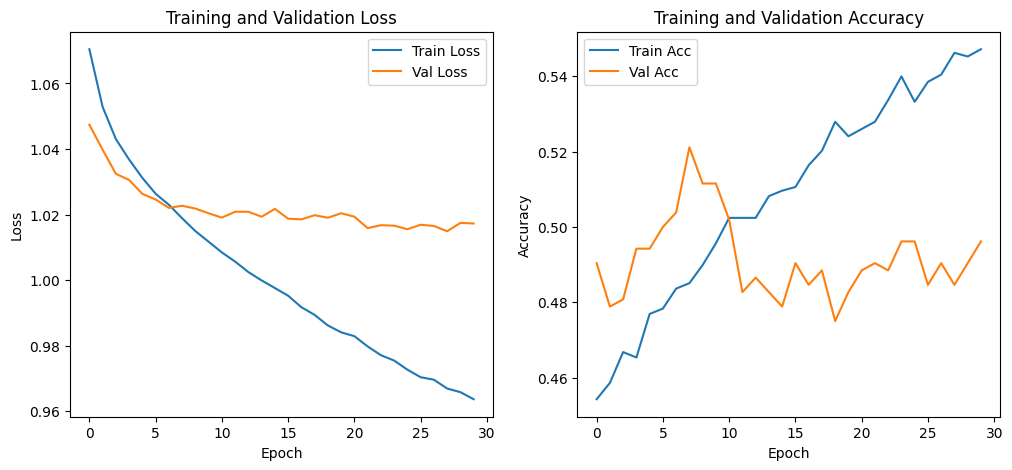

In [49]:
plt.figure(figsize=(12,5))

# Loss plot
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


Confusion Matrix:
 [[ 42  23  88]
 [ 20   9  83]
 [ 32  16 207]]


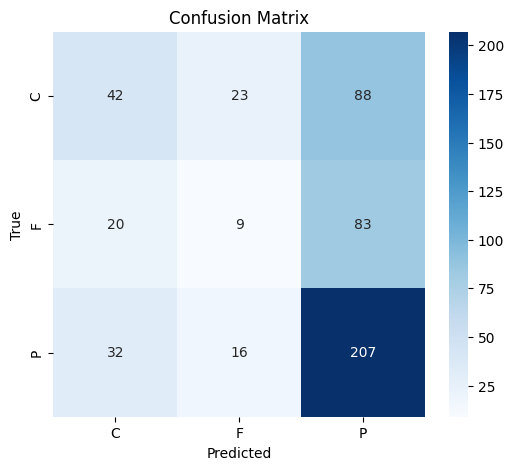

In [50]:

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

import seaborn as sns
import numpy as np


class_labels = le.classes_

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
